## Model Result Analysis

In [521]:
# change cwd above src
import os
if str(os.getcwd())[-3:] == 'src': 
    os.chdir(str(os.getcwd())+'/..')
    print(os.getcwd())

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import datetime
import yaml
from abc import ABCMeta, abstractmethod
from sklearn.model_selection import TimeSeriesSplit
from visualization.visualize import plot_model_evaluation

In [522]:
# get list of experiments run
experiment_files = [experiment.split('/')[-1] for experiment in glob("results/experiments/*", recursive = True)]
experiments = [experiment.replace('_', ' ') for experiment in experiment_files]
print('DIFFERENT EXPERIMENTS RUN...\n')
for i, experiment in enumerate(experiments):
    print(f"    {i+1}. {experiment}")

DIFFERENT EXPERIMENTS RUN...

    1. ANN DWT WINDOWED
    2. SARIMA BASIC 24
    3. 1DCNN DIURNAL 8WEEK END
    4. SARIMA END TEMP
    5. SARIMA BASIC 168
    6. TEST
    7. 1DCNN RESIDUAL 4WEEK END
    8. ANN SARIMA RESIDUAL FRAGMENT
    9. 1DCNN DIURNAL 2WEEK END
    10. SARIMA DIURNAL 4WEEK END
    11. 1DCNN END IMPUTE ANOMALY REMOVED
    12. 1DCNN RESIDUAL 16WEEK END
    13. 1DCNN RESIDUAL 8WEEK END WEATHER
    14. SARIMA DIURNAL 8WEEK END
    15. ANN CEEMDAN FRAGMENTS
    16. GRU DIURNAL FRAGMENT
    17. ANN BASIC
    18. ANN BASIC V2
    19. SARIMAX EXOG
    20. ANN DIURNAL FRAGMENT
    21. PLOTTING
    22. 1DCNN DIURNAL FRAGMENT
    23. SARIMA END WEEKEND HOLIDAY
    24. GRU SARIMAX FRAGMENTS
    25. 1DCNN DIURNAL 16WEEK END
    26. 1DCNN RESIDUAL 8WEEK END
    27. 1DCNN DIURNAL 52WEEK END
    28. ANN BASIC FRAGMENT
    29. 1DCNN RESIDUAL 8WEEK END TEMP
    30. SARIMA DIURNAL 52WEEK END
    31. SARIMA DIURNAL 2WEEK END
    32. ANN BASIC VIRTUAL
    33. 1DCNN DIURNAL 4WEEK END
  

In [523]:
# Print multi validation metric for each experiment
report_metrics = ['MSE', 'MAPE', 'RMSE', 'MAE', 'error_std']
comparison_df = pd.DataFrame(index=report_metrics)
forecast_datasets = {}

# iterate over experiments
for n, test in enumerate(experiment_files): 
    print(f"\n{n+1}. {experiments[n]}")

    # pre-allocate forecast dict
    forecast_datasets[experiments[n]] = {}

    # get path to experiment result file
    path = "results/experiments/"+test+"/*"
    tests = [test[:-4] for test in glob(path, recursive = True)]
    forecasts = [forecast for forecast in tests if forecast.split('_')[-1] == 'forecast']
    metrics  = [metric for metric in tests if metric.split('_')[-1] == 'metrics']
    
    # separate forecast results and join decompositions
    for forecast in forecasts:
        df_forecast = pd.read_csv(forecast+'.csv')
        if ('CEEMDAN' in forecast.split('/')[-1].split('_')) or ('DWT' in forecast.split('/')[-1].split('_')): 
            label = ' '.join(forecast.split('/')[-1].split('_')[1].upper())
            # sum decomposition elements
            if label not in forecast_datasets[experiments[n]].keys():
                forecast_datasets[experiments[n]][label] = df_forecast
            else: 
                forecast_datasets[experiments[n]][label] += df_forecast
        else: 
            label = ' '.join(forecast.split('/')[-1].split('_')[1].upper())
            forecast_datasets[experiments[n]][label] = df_forecast

    # separate metric results
    for metric in metrics:
        # assign label
        if ('CEEMDAN' not in metric.split('/')[-1].split('_')) or ('DWT' not in metric.split('/')[-1].split('_')): 
            label = ' '.join([experiments[n]] + [metric.split('/')[-1].split('_')[1].upper()])
            #print(f"\n{label}") 
            # get table of metrics
            df_metric = pd.read_csv(metric+'.csv').set_index('Fold')
            df_metric = df_metric.rename(columns={col: '_'.join(col.split('_')[:-1]) for col in df_metric.columns if col.split('_')[-1] == 'mean'})
            mean_vals = df_metric.loc['mean', report_metrics].T
            comparison_df[str(label)] = mean_vals

# get metric for DWT and CEEMDAN
# Combine decomposed forecasts
report_metrics = ['MSE', 'MSE_std', 'MAPE', 'MAPE_std', 'MAE', 'RMSE']
tests = [test for test in forecast_datasets.keys() if ('DWT' in test.split()) or ('CEEMDAN' in test.split())]
for experiment in tests: 
    # key metrics
    for dma in forecast_datasets[experiment].keys(): 
        no_folds = max([int(col[-3]) for col in forecast_datasets[experiment][dma].columns])+1
        no_test = max([int(col[-1]) for col in forecast_datasets[experiment][dma].columns])+1
        pointer = 0
        width_df = int(forecast_datasets[experiment][dma].shape[1] / (no_folds * no_test))
        metrics = pd.DataFrame()

        for test in range(no_test):
            for fold in range(no_folds): 
                forecast_df = forecast_datasets[experiment][dma]
                forecast_df = forecast_df.iloc[:, pointer: pointer+width_df].rename(columns={col: col[:-9] for col in forecast_df.columns})

                if (test == 0) and (fold == 0): 
                    metrics = decomposition_metrics(forecast_df)
                else: 
                    metrics = pd.concat([metrics, decomposition_metrics(forecast_df)])
                
                # move to next fold
                pointer += width_df
        
        # get avg run
        forecast_avg = forecast_datasets[experiment][dma].copy()
        forecast_avg = forecast_avg.rename(columns={col: col[:-9] for col in forecast_avg.columns})
        for col in forecast_avg.columns.unique(): 
            forecast_datasets[experiment][dma]['mean_'+col+'_fold_0_0'] = forecast_avg[col].mean(axis=1)
            print(forecast_datasets[experiment][dma]['mean_'+col+'_fold_0_0'])

        metrics.loc['mean', :] = metrics.mean()
        metrics.loc['std', :] = metrics.std()

        metrics = metrics.loc['mean', report_metrics]
        comparison_df[experiment+' '+dma] = metrics
    
    


1. ANN DWT WINDOWED

2. SARIMA BASIC 24

3. 1DCNN DIURNAL 8WEEK END

4. SARIMA END TEMP

5. SARIMA BASIC 168

6. TEST

7. 1DCNN RESIDUAL 4WEEK END

8. ANN SARIMA RESIDUAL FRAGMENT

9. 1DCNN DIURNAL 2WEEK END

10. SARIMA DIURNAL 4WEEK END

11. 1DCNN END IMPUTE ANOMALY REMOVED

12. 1DCNN RESIDUAL 16WEEK END

13. 1DCNN RESIDUAL 8WEEK END WEATHER

14. SARIMA DIURNAL 8WEEK END

15. ANN CEEMDAN FRAGMENTS

16. GRU DIURNAL FRAGMENT

17. ANN BASIC

18. ANN BASIC V2

19. SARIMAX EXOG

20. ANN DIURNAL FRAGMENT

21. PLOTTING

22. 1DCNN DIURNAL FRAGMENT

23. SARIMA END WEEKEND HOLIDAY

24. GRU SARIMAX FRAGMENTS

25. 1DCNN DIURNAL 16WEEK END

26. 1DCNN RESIDUAL 8WEEK END

27. 1DCNN DIURNAL 52WEEK END

28. ANN BASIC FRAGMENT

29. 1DCNN RESIDUAL 8WEEK END TEMP

30. SARIMA DIURNAL 52WEEK END

31. SARIMA DIURNAL 2WEEK END

32. ANN BASIC VIRTUAL

33. 1DCNN DIURNAL 4WEEK END

34. SARIMAX CEEMDAN

35. 1DCNN RESIDUAL FRAGMENT


/var/folders/wl/wvdbqtqs2yx6dmcfym05k19m0000gn/T/ipykernel_40273/106801785.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  comparison_df[str(label)] = mean_vals
/var/folders/wl/wvdbqtqs2yx6dmcfym05k19m0000gn/T/ipykernel_40273/106801785.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  comparison_df[str(label)] = mean_vals
/var/folders/wl/wvdbqtqs2yx6dmcfym05k19m0000gn/T/ipykernel_40273/106801785.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh


36. SARIMA END HOUR WEEKDAY

37. SARIMA DIURNAL 16WEEK END

38. ANN CEEMDAN WINDOWED

39. SARIMAX DIURNAL

40. 1DCNN END WEEKEND HOLIDAY


/var/folders/wl/wvdbqtqs2yx6dmcfym05k19m0000gn/T/ipykernel_40273/106801785.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  comparison_df[str(label)] = mean_vals
/var/folders/wl/wvdbqtqs2yx6dmcfym05k19m0000gn/T/ipykernel_40273/106801785.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  comparison_df[str(label)] = mean_vals
/var/folders/wl/wvdbqtqs2yx6dmcfym05k19m0000gn/T/ipykernel_40273/106801785.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh


41. 1DCNN RESIDUAL 2WEEK END

42. ANN DWT FRAGMENTS


/var/folders/wl/wvdbqtqs2yx6dmcfym05k19m0000gn/T/ipykernel_40273/106801785.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  comparison_df[str(label)] = mean_vals
/var/folders/wl/wvdbqtqs2yx6dmcfym05k19m0000gn/T/ipykernel_40273/106801785.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  comparison_df[str(label)] = mean_vals
/var/folders/wl/wvdbqtqs2yx6dmcfym05k19m0000gn/T/ipykernel_40273/106801785.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh


43. 1DCNN RESIDUAL WINDOW
0      11.59
1      10.87
2       9.69
3      10.19
4       9.91
       ...  
659    13.51
660    13.17
661    10.63
662     9.90
663     8.85
Name: mean_gt_fold_0_0, Length: 664, dtype: float64
0      11.439931
1      10.960591
2       9.933451
3       9.973507
4       9.732756
         ...    
659          NaN
660          NaN
661          NaN
662          NaN
663          NaN
Name: mean_model_fold_0_0, Length: 664, dtype: float64
0      0.150069
1     -0.090591
2     -0.243451
3      0.216493
4      0.177244
         ...   
659         NaN
660         NaN
661         NaN
662         NaN
663         NaN
Name: mean_residuals_fold_0_0, Length: 664, dtype: float64
0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
         ...    
659    13.470569
660    12.752822
661    10.743122
662     8.704712
663     7.235504
Name: mean_conf_int_low_fold_0_0, Length: 664, dtype: float64
0            NaN
1            NaN
2            NaN
3

In [524]:
forecast_datasets[experiment]

{'A':      gt_fold_0_0  model_fold_0_0  residuals_fold_0_0  conf_int_low_fold_0_0  \
 0          11.27       11.609521           -0.339521                    NaN   
 1          11.86       11.610549            0.249451                    NaN   
 2          10.59       10.696692           -0.106692                    NaN   
 3           9.79       10.044587           -0.254587                    NaN   
 4           9.92       10.236562           -0.316562                    NaN   
 ..           ...             ...                 ...                    ...   
 659          NaN             NaN                 NaN                    NaN   
 660          NaN             NaN                 NaN                    NaN   
 661          NaN             NaN                 NaN                    NaN   
 662          NaN             NaN                 NaN                    NaN   
 663          NaN             NaN                 NaN                    NaN   
 
      conf_int_up_fold_0_0  forec

In [525]:
comparison_df.sort_index(axis=1)['1DCNN END IMPUTE ANOMALY REMOVED B']

MSE          0.663428
MAPE         0.048362
RMSE         0.781665
MAE          0.569029
error_std    0.681224
Name: 1DCNN END IMPUTE ANOMALY REMOVED B, dtype: float64

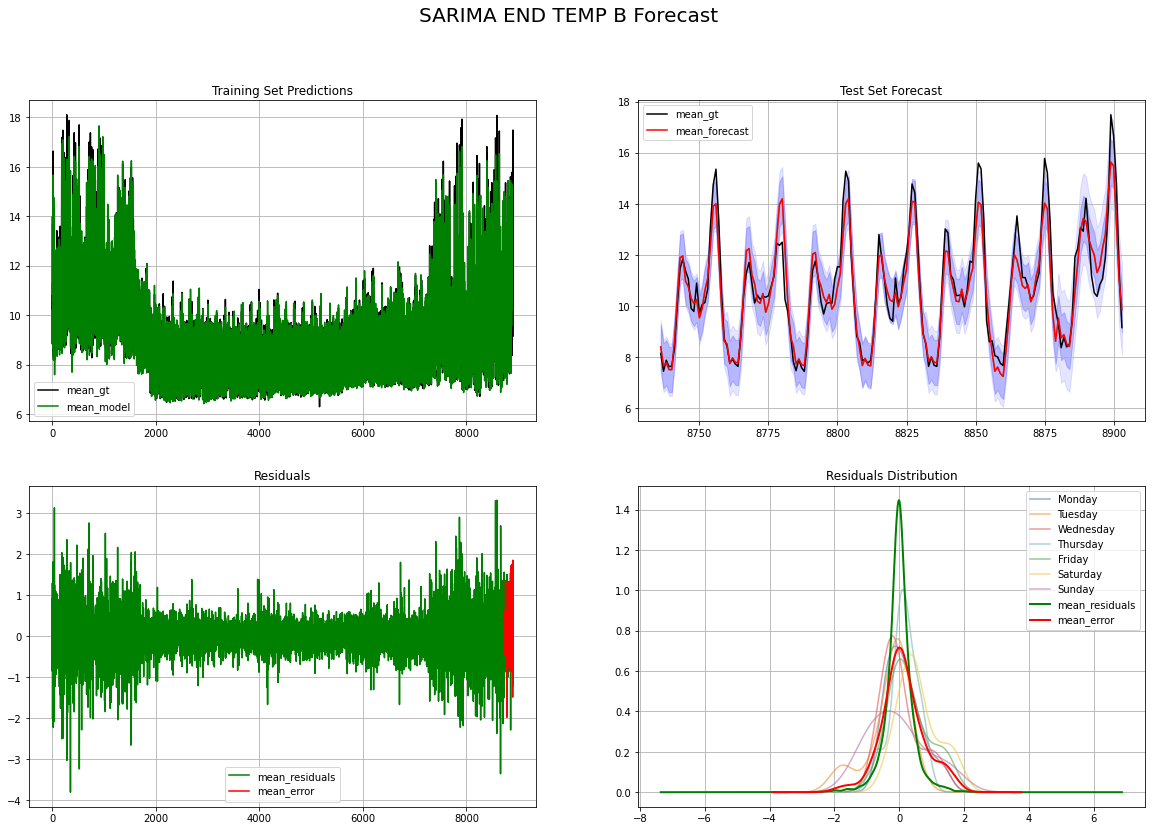

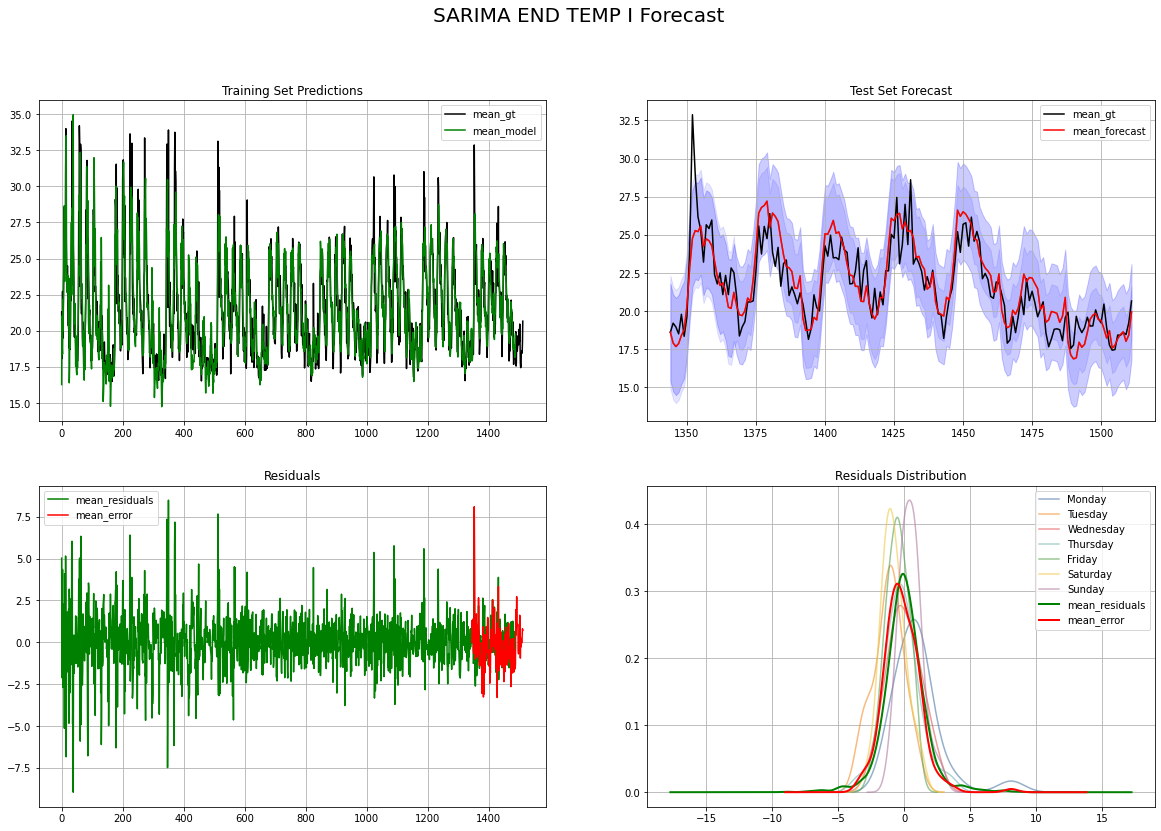

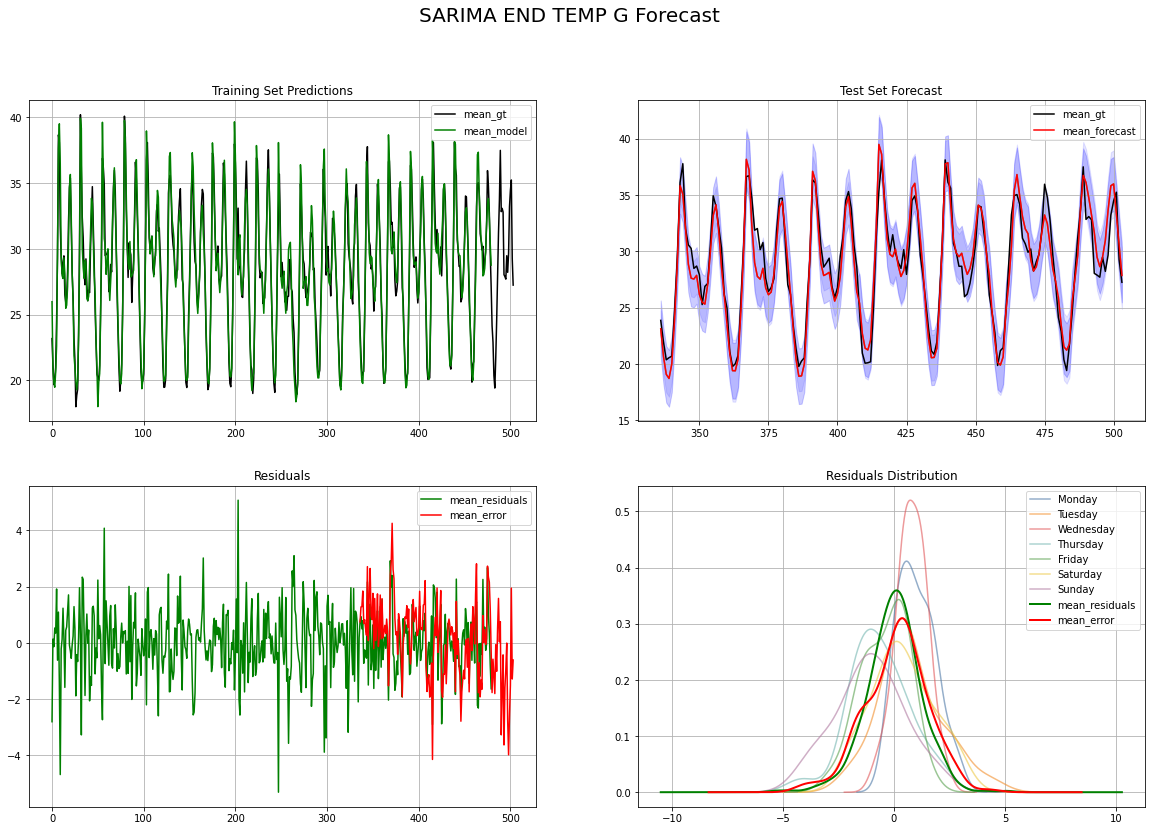

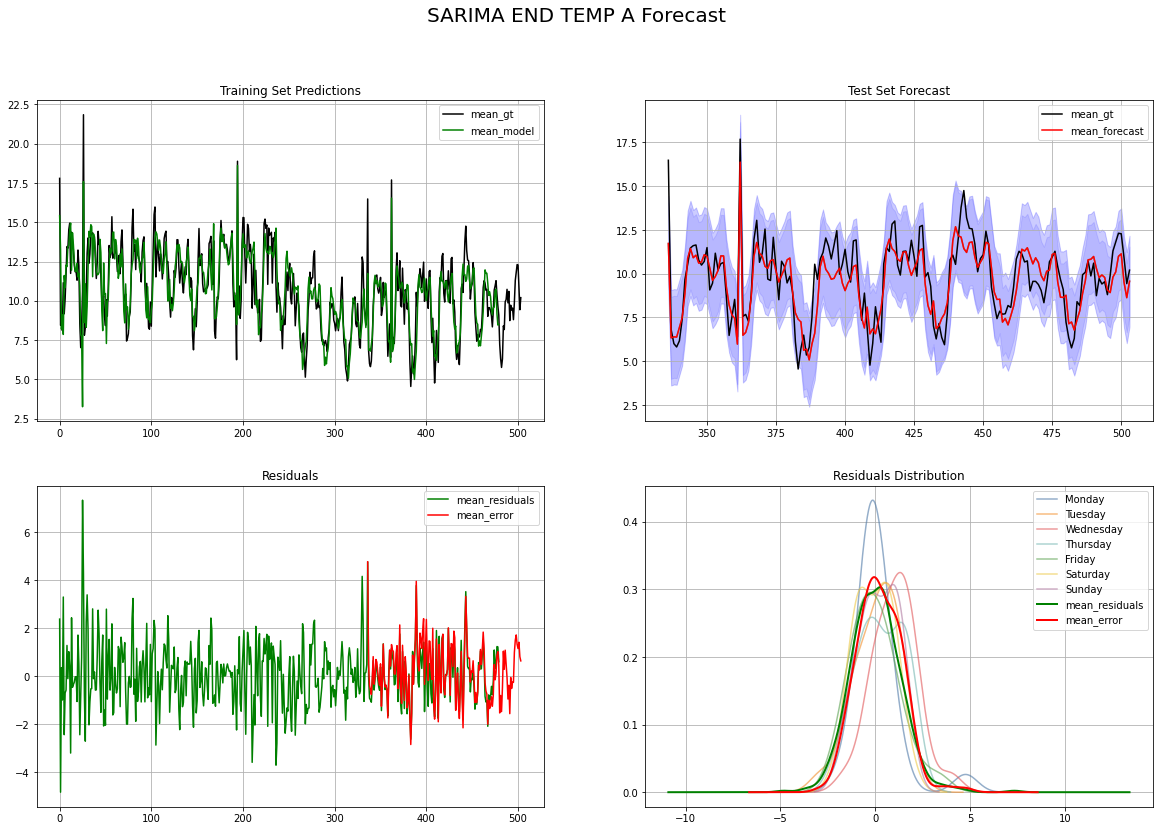

In [503]:
# plotting extended foecast and multiple cross validations
experiment = 'SARIMA END TEMP'
plot_df = forecast_datasets[experiment].keys()
plot_multi_model_evaluation(forecast_datasets, experiment=experiment)

In [398]:
def plot_multi_model_evaluation(forecast_dataset, experiment, save_dir=None, figsize=(20,13), save_fig=False):
    '''
    Plot model's predictions on training and test sets, along with key performance metrics.
    :param forecast_df: DataFrame consisting of predicted and ground truth consumption values
    :param model_name: model identifier
    :param metrics: key performance metrics
    :param figsize: size of matplotlib figure
    :param train_date: string representing date model was trained
    '''

    # assign df for specific experiment
    experiment_df = forecast_dataset[experiment]
    
    for dma in experiment_df.keys(): 
 
        # assign df for specific experiment
        experiment_df = forecast_dataset[experiment]

        # assign df for specific dma
        df_dma = experiment_df[dma].copy()
        
        no_folds = max([int(col[-3]) for col in df_dma.columns])+1
        no_test = max([int(col[-1]) for col in df_dma.columns])+1
        pointer = 0
        
        if ('DWT' in experiment.split()) or ('CEEMDAN' in experiment.split()): 
            width_df = int((df_dma.shape[1]-10) / (no_folds * no_test))
        else: 
            width_df = int((df_dma.shape[1]) / (no_folds * no_test))
        
        # initialise figure
        fig = plt.figure(figsize=figsize)
        fig.suptitle(experiment+' '+dma+' Forecast', fontsize=20)
        ax1 = fig.add_subplot(2, 2, 1)
        ax2 = fig.add_subplot(2, 2, 2)
        ax3 = fig.add_subplot(2, 2, 3)
        ax4 = fig.add_subplot(2, 2, 4)

        colours = [
            "#4E79A7",  # Blue
            "#F28E2B",  # Orange
            "#E15759",  # Red
            "#76B7B2",  # Teal
            "#59A14F",  # Green
            "#EDC948",  # Yellow
            "#B07AA1"   # Purple
                ]

        # iterate over each fold
        for test in range(no_test): 
            for fold in range(no_folds):
                forecast_df = df_dma.rename(columns={col: col[:-9] for col in df_dma.columns}).copy().iloc[:, pointer: pointer+width_df]
                # Plot test performance
                forecast_df[pd.isnull(forecast_df["model"])][["forecast"]].plot(color=["grey"], y=None,
                                        title="Test Set Forecast", grid=True, ax=ax2, legend=False)
                #ax2.fill_between(x=forecast_df.index, y1=forecast_df['pred_int_low'], y2=forecast_df['pred_int_up'], color='b', alpha=0.2)
                #ax2.fill_between(x=forecast_df.index, y1=forecast_df['conf_int_low'], y2=forecast_df['conf_int_up'], color='b', alpha=0.3)
                #ax2.set(xlabel=None)

                # Plot residuals
                #forecast_df[["residuals", "error"]].plot(ax=ax3, color=["green", "red"], title="Residuals", grid=True)
                #ax3.set(xlabel=None)
                # Plot residuals distribution
                forecast_df["error"].plot(ax=ax4, color=colours[fold], kind='kde', y=None,
                                        title="Individual Error Distribution", grid=True, legend=False, alpha=0.6)
                ax4.set(ylabel=None)

                if save_fig:
                    save_dir = cfg['PATHS']['FORECAST_VISUALIZATIONS'] if save_dir is None else save_dir
                    plt.savefig(save_dir + '/' + model_name + '_eval_' +
                                train_date + '.png')
                
                # update pointer
                pointer += width_df 

        # day of week legend for residual distribution
        ax4_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        leg = ax4.legend(ax4_labels, loc='right', bbox_to_anchor=(1.3, 0.5),
        fancybox=False, shadow=False, ncol=1, edgecolor='w', borderpad=0.5)
        leg.get_frame().set_linewidth(0.5)


        # plot mean results
        forecast_df = df_dma.rename(columns={col: col[:-9] for col in df_dma.columns}).copy()
        forecast_avg = forecast_datasets[experiment][dma].copy()
        forecast_avg = forecast_avg.rename(columns={col: col[:-9] for col in forecast_avg.columns})
        for col in forecast_avg.columns.unique(): 
            forecast_df['mean_'+col] = forecast_avg[col].mean(axis=1)

        # Plot test performance
        if "test_pred" in forecast_df.columns:
            if 'SARIMA' not in experiment.split(): 
                forecast_df[pd.isnull(df_dma["model_fold_0_0"])][["mean_gt", "mean_forecast", "mean_test_pred"]].plot(color=["black", "red", "yellow"],
                                                                               title="Test Set Forecast", grid=True, ax=ax2)
            else:
                forecast_df[pd.isnull(df_dma["model_fold_0_0"])][["mean_gt", "mean_forecast"]].plot(color=["black", "red"],
                                                                               title="Test Set Forecast", grid=True, ax=ax2)
        else:
            forecast_df[pd.isnull(df_dma["model_fold_0_0"])][["mean_gt", "mean_forecast"]].plot(color=["black", "red"],
                                                                                title="Test Set Forecast", grid=True, ax=ax2)
        ax2.fill_between(x=forecast_df.index, y1=forecast_df['mean_pred_int_low'], y2=forecast_df['mean_pred_int_up'], color='b', alpha=0.1)
        ax2.fill_between(x=forecast_df.index, y1=forecast_df['mean_conf_int_low'], y2=forecast_df['mean_conf_int_up'], color='b', alpha=0.2)
        ax2.set(xlabel=None)
        
        # plot train performance
        forecast_df[["mean_gt", "mean_model"]].plot(color=["black", "green"], title="Training Set Predictions",
                                                                                    grid=True, ax=ax1)
        ax1.set(xlabel=None)
        
        # plot residuals
        forecast_df[["mean_residuals", "mean_error"]].plot(ax=ax3, color=["green", "red"], title="Residuals", grid=True)
        ax3.set(xlabel=None)

        # Plot residuals distribution
        forecast_df[["mean_residuals", "mean_error"]].plot(ax=ax4, color=["green", "red"], kind='kde',
                                        title="Residuals Distribution", grid=True, linewidth=2)
        ax4.set(ylabel=None)

        # legends
        """ ax2_labels = ['data', 'mean forecast', 'mean single-step prediction', 'mean prediction interval', 'mean confidence interval', 'individual test forcasts']
        leg = ax2.legend(ax2_labels, loc='right', bbox_to_anchor=(1.3, 0.5),
        fancybox=False, shadow=False, ncol=1, edgecolor='w', borderpad=0.5)
        leg.get_frame().set_linewidth(0.5)"""
    return
    

def plot_compare(forecast_dataset, experiments, save_dir=None, figsize=(20,13), save_fig=False):
    '''
    Plot model's predictions on training and test sets, along with key performance metrics.
    :param forecast_df: DataFrame consisting of predicted and ground truth consumption values
    :param model_name: model identifier
    :param metrics: key performance metrics
    :param figsize: size of matplotlib figure
    :param train_date: string representing date model was trained
    '''
    # assign df for specific experiment
    experiment_df = forecast_dataset[experiment]

    for dma in experiment_df.keys(): 
        
        # initialise figure
        fig = plt.figure(figsize=figsize)
        fig.suptitle(experiment+' '+dma+' Forecast', fontsize=20)
        ax1 = fig.add_subplot(2, 2, 1)
        ax2 = fig.add_subplot(2, 2, 2)
        ax3 = fig.add_subplot(2, 2, 3)
        ax4 = fig.add_subplot(2, 2, 4)

        for experiment in experiments:
            # assign df for specific experiment
            experiment_df = forecast_dataset[experiment]

            # assign df for specific dma
            df_dma = experiment_df[dma].copy()
            
            no_folds = max([int(col[-3]) for col in df_dma.columns])+1
            no_test = max([int(col[-1]) for col in df_dma.columns])+1
            pointer = 0
            
            if ('DWT' in experiment.split()) or ('CEEMDAN' in experiment.split()): 
                width_df = int((df_dma.shape[1]-10) / (no_folds * no_test))
            else: 
                width_df = int((df_dma.shape[1]) / (no_folds * no_test))

            colours = [
                "#4E79A7",  # Blue
                "#F28E2B",  # Orange
                "#E15759",  # Red
                "#76B7B2",  # Teal
                "#59A14F",  # Green
                "#EDC948",  # Yellow
                "#B07AA1"   # Purple
                    ]

            # plot mean results
            forecast_df = df_dma.rename(columns={col: col[:-9] for col in df_dma.columns}).copy()
            forecast_avg = forecast_datasets[experiment][dma].copy()
            forecast_avg = forecast_avg.rename(columns={col: col[:-9] for col in forecast_avg.columns})
            for col in forecast_avg.columns.unique(): 
                forecast_df['mean_'+col] = forecast_avg[col].mean(axis=1)

            # Plot test performance
            if "test_pred" in forecast_df.columns:
                if 'SARIMA' not in experiment.split(): 
                    forecast_df[pd.isnull(df_dma["model_fold_0_0"])][["mean_gt", "mean_forecast", "mean_test_pred"]].plot(color=["black", "red", "yellow"],
                                                                                title="Test Set Forecast", grid=True, ax=ax2)
                else:
                    forecast_df[pd.isnull(df_dma["model_fold_0_0"])][["mean_gt", "mean_forecast"]].plot(color=["black", "red"],
                                                                                title="Test Set Forecast", grid=True, ax=ax2)
            else:
                forecast_df[pd.isnull(df_dma["model_fold_0_0"])][["mean_gt", "mean_forecast"]].plot(color=["black", "red"],
                                                                                    title="Test Set Forecast", grid=True, ax=ax2)
            #ax2.fill_between(x=forecast_df.index, y1=forecast_df['mean_pred_int_low'], y2=forecast_df['mean_pred_int_up'], color='b', alpha=0.1)
            #ax2.fill_between(x=forecast_df.index, y1=forecast_df['mean_conf_int_low'], y2=forecast_df['mean_conf_int_up'], color='b', alpha=0.2)
            #ax2.set(xlabel=None)
            
            # plot residuals
            forecast_df[["mean_error"]].plot(ax=ax3, color=["red"], title="Residuals", grid=True)
            ax3.set(xlabel=None)

            # Plot residuals distribution
            forecast_df[["mean_error"]].plot(ax=ax4, color=["red"], kind='kde',
                                            title="Residuals Distribution", grid=True, linewidth=2)
            ax4.set(ylabel=None)

    return

def decomposition_metrics(forecast_df):
    '''
    Return metrics relating to mode performance for a single fold.
    :param forecast_df: DataFrame consisting of predicted and ground truth consumption values
    '''
    metrics = {}
    metrics['residuals_mean'] = forecast_df["residuals"].mean()
    metrics['residuals_std'] = forecast_df["residuals"].std()
    metrics['error_mean'] = forecast_df["error"].mean()
    metrics['error_std'] = forecast_df["error"].std()
    metrics['MAE'] = forecast_df["error"].apply(lambda x: np.abs(x)).mean()
    forecast_df["error_pct"] = forecast_df["error"] / forecast_df["gt"]
    metrics['MAPE'] = forecast_df["error_pct"].apply(lambda x: np.abs(x)).mean()
    metrics['MSE'] = forecast_df["error"].apply(lambda x: x ** 2).mean()
    metrics['RMSE'] = np.sqrt(metrics['MSE'])  # root mean squared error
    metrics['MAE_std'] = forecast_df["error"].apply(lambda x: np.abs(x)).std()
    metrics['MAPE_std'] = forecast_df["error_pct"].apply(lambda x: np.abs(x)).std()
    metrics['MSE_std'] = forecast_df["error"].apply(lambda x: x ** 2).std()
    metrics_df = pd.DataFrame.from_records([metrics])

    return metrics_df

In [620]:
index[0].strftime('%m-%d')

'07-11'

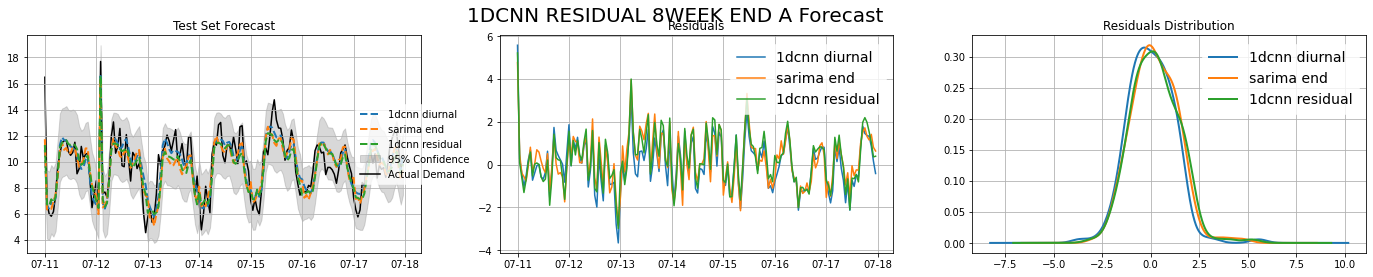

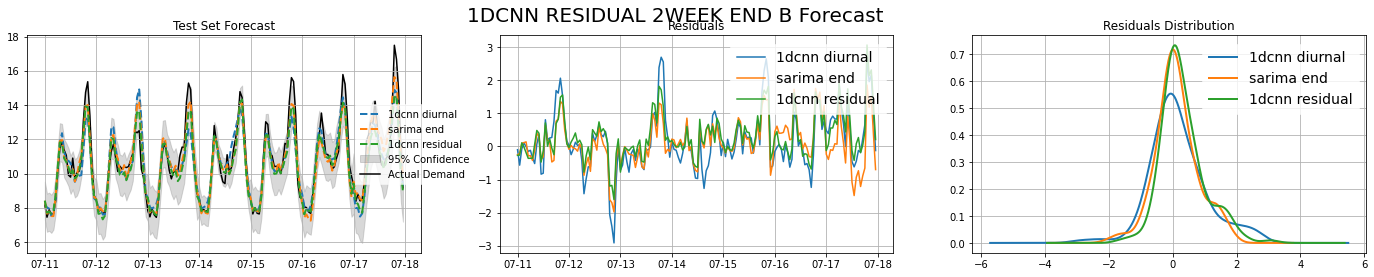

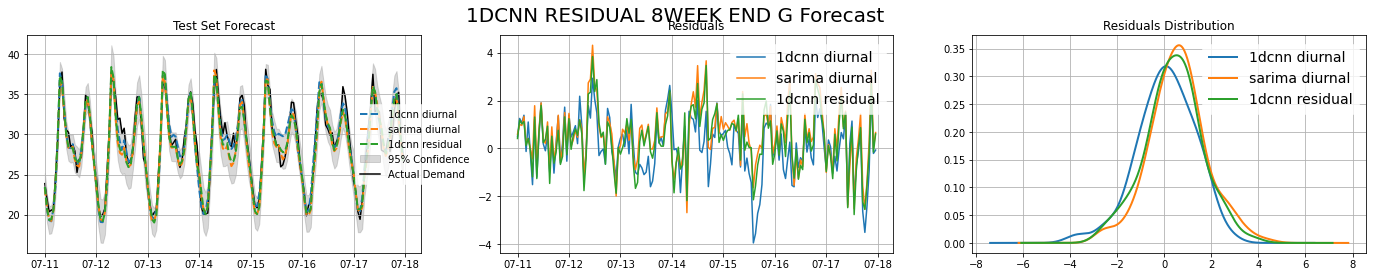

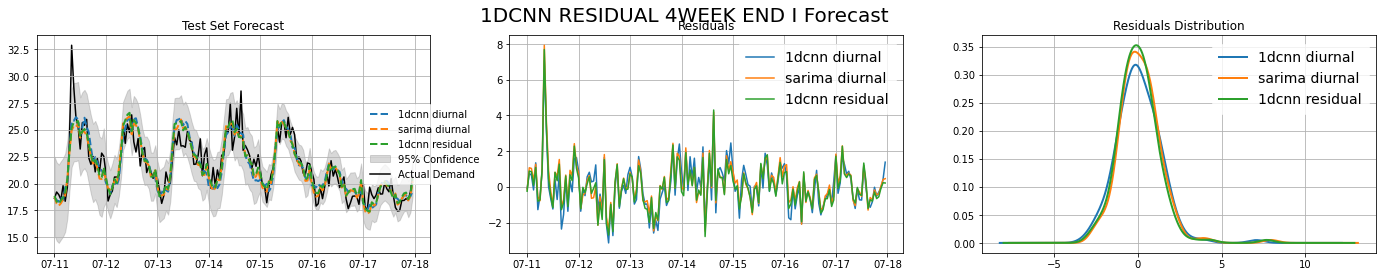

In [647]:
# comparing fragments, window, virtual
# plotting extended foecast and multiple cross validations
import matplotlib.dates as mdates

# top 3 models in DMA A
experiments = {}
experiments['A'] = ['1DCNN DIURNAL 8WEEK END', 'SARIMA END TEMP', '1DCNN RESIDUAL 2WEEK END']
# top 3 models in DMA B
experiments['B'] = ['1DCNN DIURNAL 4WEEK END', 'SARIMA END TEMP', '1DCNN RESIDUAL 8WEEK END']
# top 3 models in DMA G
experiments['G'] = ['1DCNN DIURNAL 8WEEK END', 'SARIMA DIURNAL 2WEEK END', '1DCNN RESIDUAL 4WEEK END']
# top 3 models in DMA I
experiments['I'] = ['1DCNN DIURNAL 8WEEK END', 'SARIMA DIURNAL 8WEEK END', '1DCNN RESIDUAL 8WEEK END']

# assign df for specific experiment
forecast_dataset = forecast_datasets
colours = ['#1f77b4', '#ff7f0e', '#2ca02c']
index = [date.strftime('%m-%d') for date in pd.date_range('2022-07-11', '2022-07-18')]

for dma in experiments.keys(): 
    # initialise figure
    fig = plt.figure(figsize=(24,4))
    fig.suptitle(experiment+' '+dma+' Forecast', fontsize=20)
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)
    for i, experiment in enumerate(experiments[dma]): 
    
        # assign df for specific experiment
        experiment_df = forecast_dataset[experiment]

        # assign df for specific dma
        df_dma = experiment_df[dma].copy()
        #df_dma = df_dma.reset_index(drop=True)
        
        no_folds = max([int(col[-3]) for col in df_dma.columns])+1
        no_test = max([int(col[-1]) for col in df_dma.columns])+1
        pointer = 0
        
        if ('DWT' in experiment.split()) or ('CEEMDAN' in experiment.split()): 
            width_df = int((df_dma.shape[1]-10) / (no_folds * no_test))
        else: 
            width_df = int((df_dma.shape[1]) / (no_folds * no_test))

        # plot mean results
        forecast_df = df_dma.rename(columns={col: col[:-9] for col in df_dma.columns}).copy()
        forecast_avg = forecast_datasets[experiment][dma].copy()
        forecast_avg = forecast_avg.rename(columns={col: col[:-9] for col in forecast_avg.columns})
        for col in forecast_avg.columns.unique(): 
            forecast_df['mean_'+col] = forecast_avg[col].mean(axis=1)

        forecast_df[pd.isnull(df_dma["model_fold_0_0"])][["mean_forecast"]].reset_index(drop=True).plot(title="Test Set Forecast", grid=True, ax=ax1, ls='--', lw=2, color=colours[i])
        ax1.set_xticks(np.arange(0, 169, 24), labels = index)
        ax1.set(xlabel=None)
        
        # plot residuals
        forecast_df[pd.isnull(df_dma["model_fold_0_0"])][["mean_error"]].reset_index(drop=True).plot(ax=ax2, title="Residuals", grid=True, legend=False)
        ax2.set_xticks(np.arange(0, 169, 24), labels = index)
        ax2.set(xlabel=None)

        # Plot residuals distribution
        forecast_df[pd.isnull(df_dma["model_fold_0_0"])][["mean_error"]].reset_index(drop=True).plot(ax=ax3, kind='kde',
                                        title="Residuals Distribution", grid=True, linewidth=2, legend=False)
        ax3.set(ylabel=None)

    ax1.fill_between(x=forecast_df[pd.isnull(df_dma["model_fold_0_0"])].reset_index(drop=True).index, 
                    y1=forecast_df[pd.isnull(df_dma["model_fold_0_0"])]['mean_pred_int_low'], 
                    y2=forecast_df[pd.isnull(df_dma["model_fold_0_0"])]['mean_pred_int_up'], 
                    color='grey', alpha=0.3, zorder=0)
    forecast_df[pd.isnull(df_dma["model_fold_0_0"])][["mean_gt"]].reset_index(drop=True).plot(color=["black"],
                                                                            title="Test Set Forecast", grid=True, ax=ax1, legend=False, zorder=1)
    # legends
    ax_labels = [' '.join(model.split()[:2]).lower() for model in experiments[dma]]
    #ax_labels[1] = 'sarimax diurnal'
    ax1_labels = ax_labels + ['95% Confidence', 'Actual Demand']
    leg = ax1.legend(ax1_labels, loc='right', bbox_to_anchor=(1.15, 0.5),
    fancybox=False, shadow=False, ncol=1, edgecolor='w', borderpad=0.5)
    leg.get_frame().set_linewidth(0.5)

    ax2_labels = ax_labels
    leg = ax2.legend(ax1_labels, loc='right', bbox_to_anchor=(1, 0.8),
    fancybox=False, shadow=False, ncol=1, edgecolor='w', borderpad=0.5, fontsize=14)
    leg.get_frame().set_linewidth(0.5)

    leg = ax3.legend(ax1_labels, loc='right', bbox_to_anchor=(1, 0.8),
    fancybox=False, shadow=False, ncol=1, edgecolor='w', borderpad=0.5, fontsize=14)
    leg.get_frame().set_linewidth(0.5)


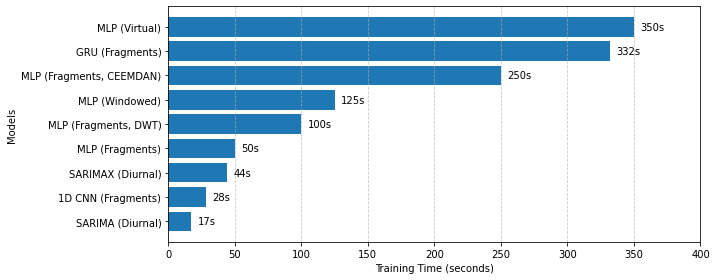

In [540]:
# train time comparison
models = ['MLP (Fragments)', 'MLP (Windowed)', 'MLP (Virtual)', 'MLP (Fragments, CEEMDAN)', 'MLP (Fragments, DWT)', '1D CNN (Fragments)', 'GRU (Fragments)', 'SARIMA (Diurnal)', 'SARIMAX (Diurnal)']
training_times = [50, 125, 350, 250, 100, 28, 332, 17, 44]
rel_times = [time / min(train_times) for time in train_times]

# Combine models and training times into a list of tuples and sort by training times
data = list(zip(models, training_times))
sorted_data = sorted(data, key=lambda x: x[1])

# Unzip the sorted data
models, training_times = zip(*sorted_data)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
bars = plt.barh(models, training_times)

# Add labels to the bars
for bar in bars:
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height() / 2, 
             f'{bar.get_width()}s', 
             va='center', ha='left', color='black', fontsize=10)

# Add titles and labels
#plt.title('7-Fold Training Times of Different Models with 4 Weeks of Training Data')
plt.xlabel('Training Time (seconds)')
plt.ylabel('Models')

# Customize the plot appearance
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

max_training_time = max(sorted_training_times)
plt.xlim(0, max_training_time + 50) 

# Show the plot
plt.show()

In [439]:
df_dma.reset_index(drop=True)
df_dma

,index,gt_fold_0_0,model_fold_0_0,residuals_fold_0_0,conf_int_low_fold_0_0,conf_int_up_fold_0_0,forecast_fold_0_0,error_fold_0_0,pred_int_low_fold_0_0,pred_int_up_fold_0_0,...,gt_fold_6_1,model_fold_6_1,residuals_fold_6_1,conf_int_low_fold_6_1,conf_int_up_fold_6_1,forecast_fold_6_1,error_fold_6_1,pred_int_low_fold_6_1,pred_int_up_fold_6_1,test_pred_fold_6_1
0,450,8.10,9.599148,-1.499148,NaN,NaN,NaN,NaN,NaN,NaN,...,8.10,8.738565,-0.638564,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,451,8.82,9.862120,-1.042120,NaN,NaN,NaN,NaN,NaN,NaN,...,8.82,9.295588,-0.475588,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,452,8.97,10.319893,-1.349893,NaN,NaN,NaN,NaN,NaN,NaN,...,8.97,10.088572,-1.118572,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,453,10.56,10.530345,0.029655,NaN,NaN,NaN,NaN,NaN,NaN,...,10.56,10.644713,-0.084713,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,454,11.51,10.598457,0.911543,NaN,NaN,NaN,NaN,NaN,NaN,...,11.51,11.030004,0.479996,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.31,NaN,NaN,9.450384,13.487429,11.468907,0.841093,8.788618,14.149195,11.289882
196,646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.28,NaN,NaN,8.313188,12.350232,10.331710,1.948290,7.651422,13.011998,10.236477
197,647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.93,NaN,NaN,7.672080,11.709124,9.690602,1.239398,7.010314,12.370890,9.676864
198,648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.43,NaN,NaN,6.295622,10.332666,8.314144,1.115856,5.633856,10.994432,8.272061
